In [1]:
!pip install ppscore

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 62.4 MB/s eta 0:00:00
  Created wheel for ppscore: filename=ppscore-1.3.0-py2.py3-none-any.whl size=13164 sha256=0d73b1996a26da3f6f660633402a54c4816d58bf5bfb28903fd14a70edf9ca3b
  Stored in directory: /root/.cache/pip/wheels/7e/45/08/bb444e1bca6a2bc3795707de9edd87ec1976dd8b3570fa7abf
Successfully built ppscore
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
mizani 0.13.1 requires pandas>=2.2.0, but you have pandas 1.5.3 which i

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import IsolationForest
import ppscore as pps
import seaborn as sns
import matplotlib.pyplot as plt


In [7]:
# Load the dataset
df = pd.read_csv("/content/adult_with_headers.csv")

In [8]:
# Data Exploration
print(df.info())
print(df.describe())
print(df.isnull().sum())

# Handling Missing Values
df = df.dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None
                age        fnlwgt  education_num  capital_gain  capital_loss  \
count  3

In [9]:
# Scaling Numerical Features
numerical_features = df.select_dtypes(include=["int64", "float64"]).columns
scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler()

df_standard_scaled = df.copy()
df_minmax_scaled = df.copy()

df_standard_scaled[numerical_features] = scaler_standard.fit_transform(df[numerical_features])
df_minmax_scaled[numerical_features] = scaler_minmax.fit_transform(df[numerical_features])


In [10]:
# Encoding Categorical Variables
categorical_features = df.select_dtypes(include=["object"]).columns

# One-Hot Encoding for variables with <5 categories
for col in categorical_features:
    if df[col].nunique() < 5:
        df = pd.get_dummies(df, columns=[col], drop_first=True)
    else:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

In [11]:
# Feature Engineering
# Creating new features (example: Age Binning, Feature Interaction)
df["age_bins"] = pd.cut(df["age"], bins=[0, 30, 50, 100], labels=["Young", "Middle", "Senior"])
df["capital_diff"] = df["capital_gain"] - df["capital_loss"]


In [12]:
# Log Transformation for Skewed Features
df["log_capital_gain"] = np.log1p(df["capital_gain"])

In [13]:
# Outlier Detection using Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(df[numerical_features])
df = df[outliers == 1]

In [14]:
# Feature Selection using PPS
pps_matrix = pps.matrix(df)
print(pps_matrix.sort_values(by="ppscore", ascending=False))

                 x                 y  ppscore            case  is_valid_score  \
0              age               age      1.0  predict_itself            True   
152           race              race      1.0  predict_itself            True   
57       education         education      1.0  predict_itself            True   
58       education     education_num      1.0      regression            True   
75   education_num         education      1.0      regression            True   
..             ...               ...      ...             ...             ...   
138   relationship    native_country      0.0      regression            True   
140   relationship      income_ >50K      0.0      regression            True   
142   relationship      capital_diff      0.0      regression            True   
143   relationship  log_capital_gain      0.0      regression            True   
172   capital_gain      capital_loss      0.0      regression            True   

                  metric  b

<ipython-input-15-05e2de3aff67>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


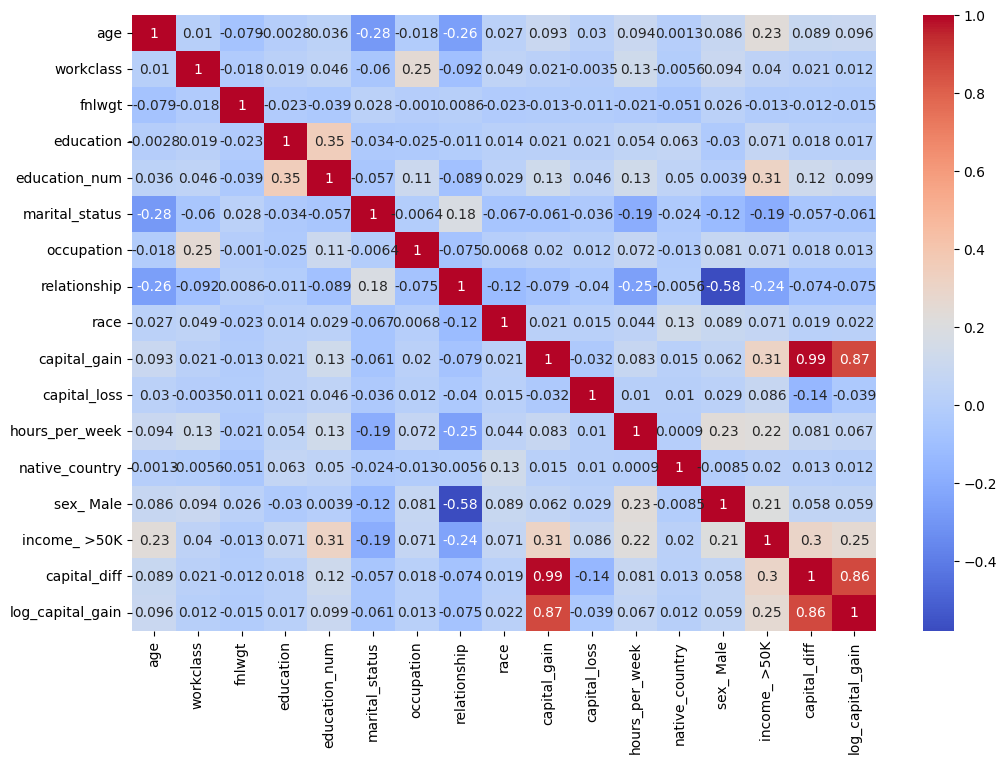

In [15]:
# Comparing PPS with Correlation Matrix
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))  # Adjust heatmap size
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()